In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [ ]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '79-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [ ]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [ ]:
#@title
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 12,
  "LEARNING_RATE": 0.00000125 * REPLICAS * 256,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 10,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-384x384',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 384,
 'LEARNING_RATE': 0.00256,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 10,
 'WIDTH': 384}

# Load data

In [ ]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-3c0c447892078c6cb0cb069958214c9fedc65fe9efc33682fef72a3e'
TRAINING_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
TEST_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [ ]:
#@title
def data_augment(image, label):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image['input_image'] = data_augment_shift(image['input_image'])
    image['input_image'] = data_augment_shear(image['input_image'])
    image['input_image'] = data_augment_rotation(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    image['input_image'] = data_augment_spatial(image['input_image'])
    image['input_image'] = data_augment_saturation(image['input_image'])
    image['input_image'] = data_augment_contrast(image['input_image'])
    image['input_image'] = data_augment_brightness(image['input_image'])

    image['input_image'] = tf.reshape(image['input_image'], [config['HEIGHT'], config['WIDTH'], config['CHANNELS']])
    
    return image, label

def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.7, upper=1.3):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)

    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [ ]:
#@title
# Datasets utility functions
def read_tfrecord(example, labeled=False, return_names=False, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    if labeled:
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        label = tf.cast(example['target'], tf.float32)
    else:
        example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    if return_names:
        image_name = example['image_name']

    image = decode_image(example['image'], height, width, channels)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    if labeled:
        if return_names:
            return {'input_image': image, 'input_meta': data}, label, image_name
        else:
            return {'input_image': image, 'input_meta': data}, label
    else:
        if return_names:
            return {'input_image': image, 'input_meta': data}, image_name
        else:
            return {'input_image': image, 'input_meta': data}

def load_dataset(filenames, labeled=False, return_names=False, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size)
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_tfrecord(example, labeled, return_names), num_parallel_calls=buffer_size)   
    return dataset

def get_dataset(filenames, labeled=True, return_names=False, ordered=False, repeated=False, augment=False, 
                batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, labeled, return_names, ordered, buffer_size)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=buffer_size)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00256 to 0.000671


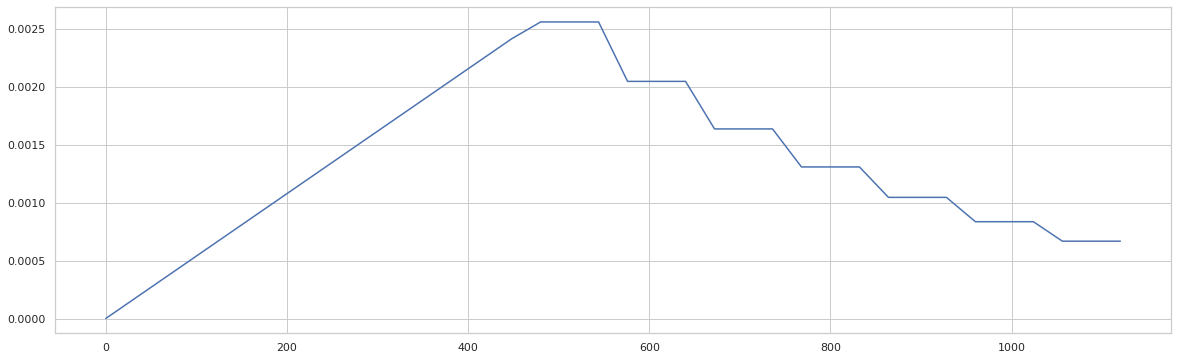

In [ ]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24519 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [ ]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [ ]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [ ]:
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_TRAIN_IMAGES = count_data_items(TRAINING_FILENAMES)
# Evaluation
eval_dataset = get_dataset(TRAINING_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=False, 
                           batch_size=1024, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TRAIN_IMAGES))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, image_name: data)

# Test
test_preds = np.zeros((NUM_TEST_IMAGES, 1)); test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=True, 
                           batch_size=1024, buffer_size=AUTO)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)

# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]
k_fold_best = k_fold.copy()

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
            
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])
            
        history = model.fit(get_dataset(train_filenames, labeled=True, return_names=False, ordered=False, repeated=True, 
                                        augment=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_dataset(valid_filenames, labeled=True, return_names=False, ordered=False, 
                                                        repeated=False, augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint],
                            verbose=2).history

        history_list.append(history)

        # Save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        # Get validation IDs
        valid_dataset = get_dataset(valid_filenames, labeled=False, return_names=True, ordered=True, repeated=False, 
                                    augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print(f'Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print(f'Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/12
102/102 - 158s - auc: 0.6820 - loss: 0.1739 - val_auc: 0.5997 - val_loss: 0.1775
Epoch 2/12
102/102 - 123s - auc: 0.7950 - loss: 0.1705 - val_auc: 0.7560 - val_loss: 0.1811
Epoch 3/12
102/102 - 131s - auc: 0.8191 - loss: 0.1679 - val_auc: 0.8403 - val_loss: 0.1688
Epoch 4/12
102/102 - 125s - auc: 0.8007 - loss: 0.1694 - val_auc: 0.8126 - val_loss: 0.1732
Epoch 5/12
102/102 - 130s - auc: 0.7897 - loss: 0.1695 - val_auc: 0.8494 - val_loss: 0.1683
Epoch 6/12
102/102 - 123s - auc: 0.8311 - loss: 0.1675 - val_auc: 0.7841 - val_loss: 0.1732
Epoch 7/12
102/102 - 124s - auc: 0.8415 - loss: 0.1670 - val_auc: 0.7959 - val_loss: 0.1728
Epoch 8/12
102/102 - 129s - auc: 0.8488 - loss: 0.1659 - val_auc: 0.8220 - val_loss: 0.1680
Epoch 9/12
102/102 - 129s - auc: 0.8762 - loss: 0.1649 - val_auc: 0.8596 - val_loss: 0.1666
Epoch 10/12
102/102 - 131s - auc: 0.8841 - loss: 0.1629 - val_auc: 0.8714 - val_loss: 0.1658
Epoch 11/12


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 158s - auc: 0.6968 - loss: 0.1744 - val_auc: 0.5612 - val_loss: 0.1816
Epoch 2/12
102/102 - 129s - auc: 0.7905 - loss: 0.1696 - val_auc: 0.6769 - val_loss: 0.1761
Epoch 3/12
102/102 - 130s - auc: 0.8053 - loss: 0.1687 - val_auc: 0.7811 - val_loss: 0.1757
Epoch 4/12
102/102 - 130s - auc: 0.8258 - loss: 0.1690 - val_auc: 0.8225 - val_loss: 0.1709
Epoch 5/12
102/102 - 124s - auc: 0.7918 - loss: 0.1692 - val_auc: 0.4851 - val_loss: 8.9382
Epoch 6/12
102/102 - 123s - auc: 0.8118 - loss: 0.1688 - val_auc: 0.7249 - val_loss: 0.2078
Epoch 7/12
102/102 - 123s - auc: 0.8429 - loss: 0.1661 - val_auc: 0.7881 - val_loss: 0.1812
Epoch 8/12
102/102 - 129s - auc: 0.8723 - loss: 0.1650 - val_auc: 0.7719 - val_loss: 0.1701
Epoch 9/12
102/102 - 129s - auc: 0.8748 - loss: 0.1650 - val_auc: 0.8515 - val_loss: 0.1683
Epoch 10/12
102/102 - 125s - auc: 0.8932 - loss: 0.1627 - val_auc: 0.8417 - val_loss: 0.1713
Epoch 11/12
102/102 - 133s - auc: 0.8839 - loss: 0.1620 - val_auc: 0.8699 - val

INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 160s - auc: 0.6795 - loss: 0.1749 - val_auc: 0.7082 - val_loss: 0.1799
Epoch 2/12
102/102 - 129s - auc: 0.7981 - loss: 0.1700 - val_auc: 0.8509 - val_loss: 0.1719
Epoch 3/12
102/102 - 125s - auc: 0.7977 - loss: 0.1694 - val_auc: 0.8386 - val_loss: 0.5055
Epoch 4/12
102/102 - 125s - auc: 0.7985 - loss: 0.1690 - val_auc: 0.7991 - val_loss: 0.2083
Epoch 5/12
102/102 - 124s - auc: 0.7924 - loss: 0.1703 - val_auc: 0.4952 - val_loss: 0.2259
Epoch 6/12
102/102 - 129s - auc: 0.8181 - loss: 0.1684 - val_auc: 0.9108 - val_loss: 0.1635
Epoch 7/12
102/102 - 124s - auc: 0.8337 - loss: 0.1677 - val_auc: 0.8831 - val_loss: 0.1645
Epoch 8/12
102/102 - 123s - auc: 0.8497 - loss: 0.1666 - val_auc: 0.8954 - val_loss: 0.1651
Epoch 9/12
102/102 - 124s - auc: 0.8641 - loss: 0.1638 - val_auc: 0.8887 - val_loss: 0.1676
Epoch 10/12
102/102 - 131s - auc: 0.8815 - loss: 0.1639 - val_auc: 0.8923 - val_loss: 0.1620
Epoch 11/12
102/102 - 126s - auc: 0.8895 - loss: 0.1621 - val_auc: 0.9137 - val

INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 159s - auc: 0.6846 - loss: 0.1740 - val_auc: 0.6920 - val_loss: 0.1779
Epoch 2/12
102/102 - 129s - auc: 0.7899 - loss: 0.1701 - val_auc: 0.7784 - val_loss: 0.1727
Epoch 3/12
102/102 - 131s - auc: 0.8175 - loss: 0.1686 - val_auc: 0.8231 - val_loss: 0.1706
Epoch 4/12
102/102 - 125s - auc: 0.8046 - loss: 0.1689 - val_auc: 0.6769 - val_loss: 0.1889
Epoch 5/12
102/102 - 124s - auc: 0.8059 - loss: 0.1693 - val_auc: 0.5987 - val_loss: 0.2438
Epoch 6/12
102/102 - 124s - auc: 0.8279 - loss: 0.1678 - val_auc: 0.7717 - val_loss: 0.1742
Epoch 7/12
102/102 - 131s - auc: 0.8433 - loss: 0.1672 - val_auc: 0.8495 - val_loss: 0.1692
Epoch 8/12
102/102 - 129s - auc: 0.8483 - loss: 0.1667 - val_auc: 0.8828 - val_loss: 0.1656
Epoch 9/12
102/102 - 131s - auc: 0.8551 - loss: 0.1647 - val_auc: 0.8622 - val_loss: 0.1650
Epoch 10/12
102/102 - 125s - auc: 0.8838 - loss: 0.1633 - val_auc: 0.8366 - val_loss: 0.1675
Epoch 11/12
102/102 - 130s - auc: 0.8885 - loss: 0.1619 - val_auc: 0.8569 - val

INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.175.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 159s - auc: 0.6853 - loss: 0.1756 - val_auc: 0.5320 - val_loss: 0.1769
Epoch 2/12
102/102 - 129s - auc: 0.7816 - loss: 0.1687 - val_auc: 0.7510 - val_loss: 0.1735
Epoch 3/12
102/102 - 125s - auc: 0.7941 - loss: 0.1696 - val_auc: 0.6952 - val_loss: 0.1801
Epoch 4/12
102/102 - 130s - auc: 0.8073 - loss: 0.1690 - val_auc: 0.8542 - val_loss: 0.1669
Epoch 5/12
102/102 - 124s - auc: 0.8252 - loss: 0.1685 - val_auc: 0.8015 - val_loss: 0.1695
Epoch 6/12
102/102 - 124s - auc: 0.8167 - loss: 0.1689 - val_auc: 0.6164 - val_loss: 0.4240
Epoch 7/12
102/102 - 124s - auc: 0.8490 - loss: 0.1666 - val_auc: 0.7091 - val_loss: 0.1914
Epoch 8/12
102/102 - 124s - auc: 0.8718 - loss: 0.1655 - val_auc: 0.7944 - val_loss: 0.1699
Epoch 9/12
102/102 - 124s - auc: 0.8802 - loss: 0.1636 - val_auc: 0.7816 - val_loss: 0.1694
Epoch 10/12
102/102 - 132s - auc: 0.8778 - loss: 0.1638 - val_auc: 0.8434 - val_loss: 0.1649
Epoch 11/12
102/102 - 126s - auc: 0.9025 - loss: 0.1615 - val_auc: 0.8632 - val

ValueError: ignored

## Model loss graph

Fold: 1


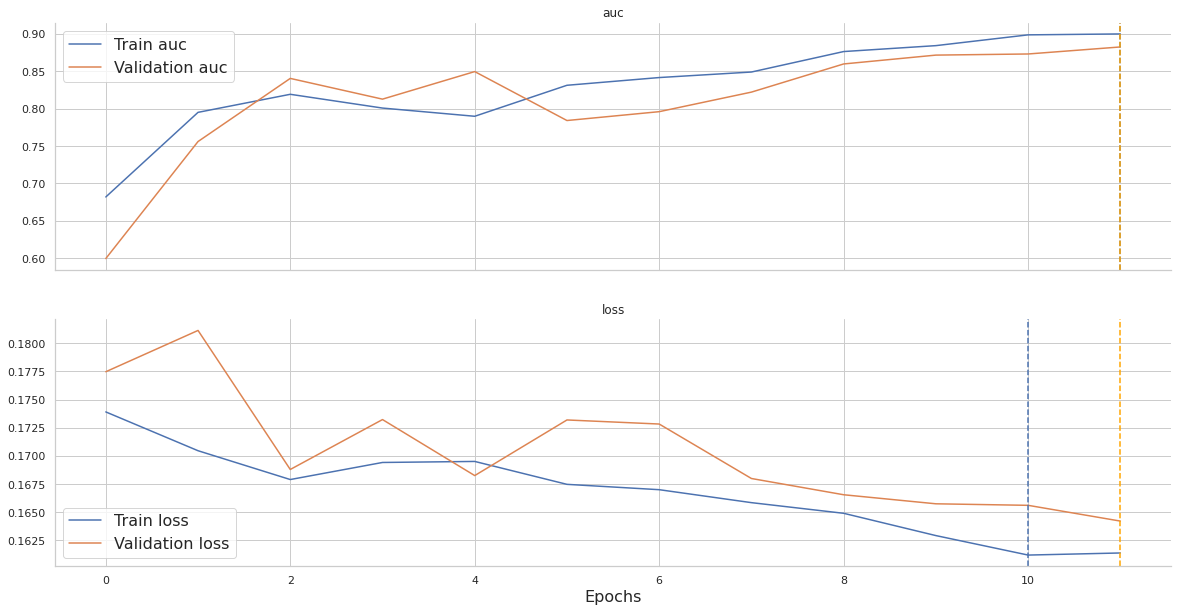

Fold: 2


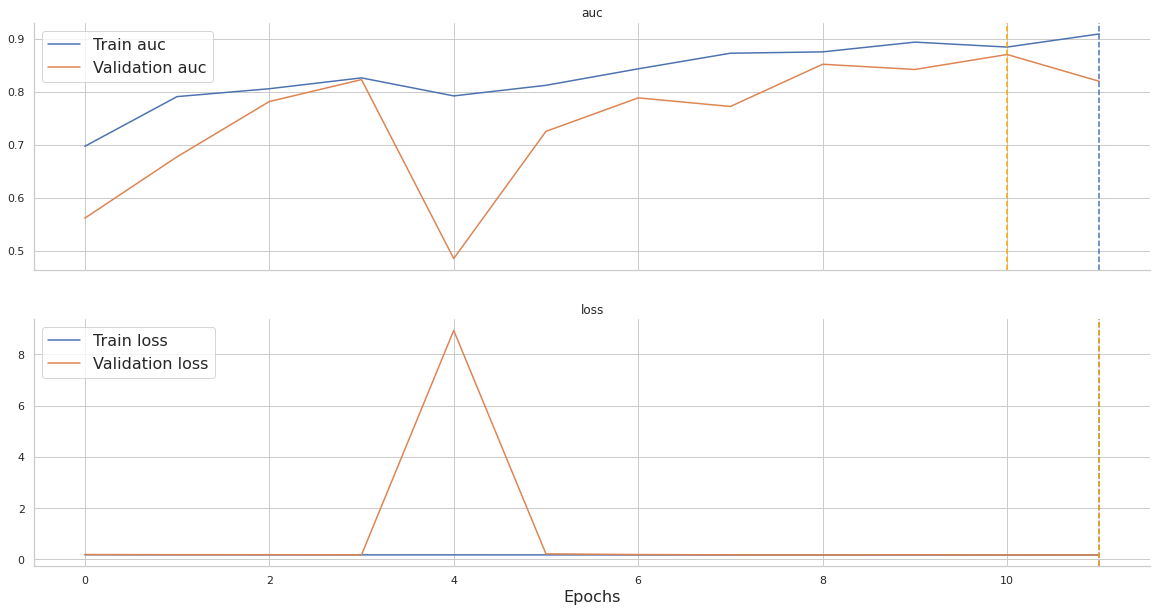

Fold: 3


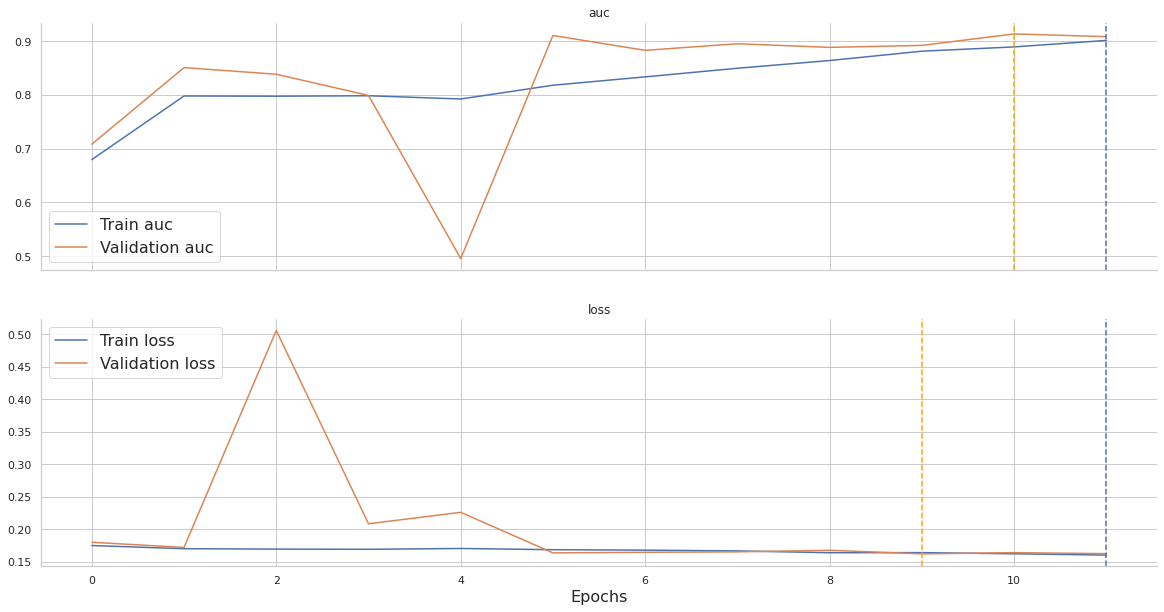

Fold: 4


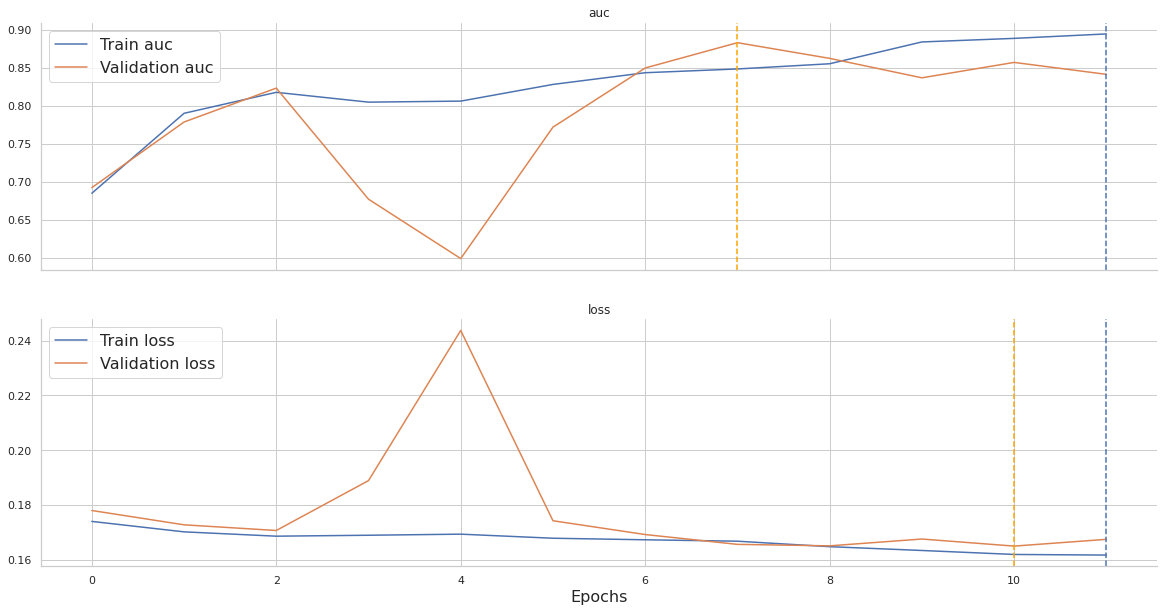

Fold: 5


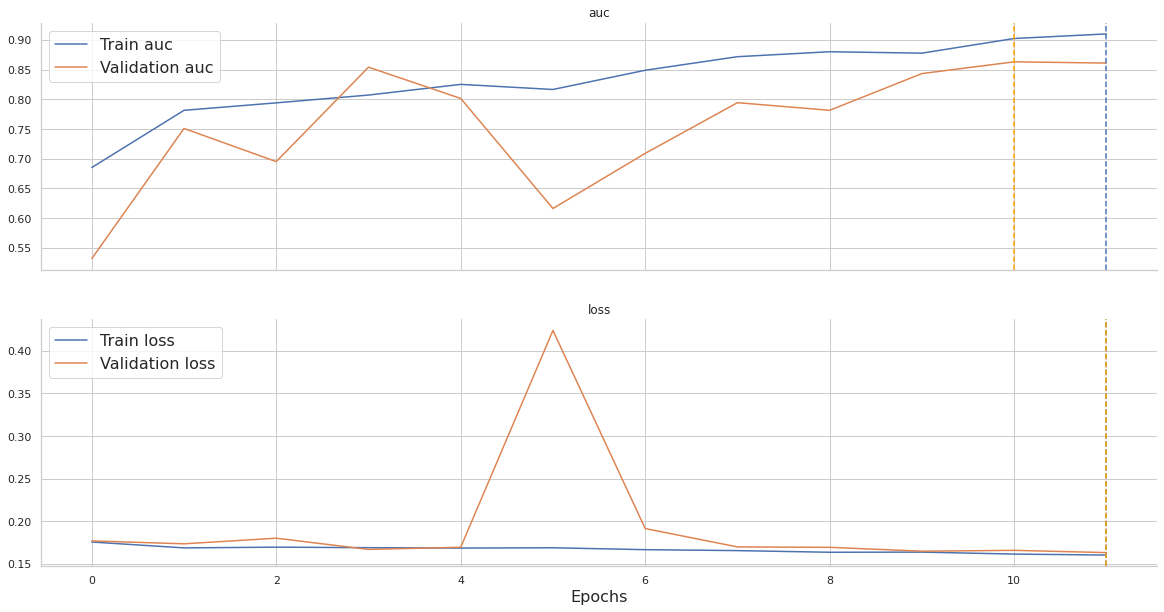

In [23]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

In [24]:
#@title
# plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [25]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.914253,0.868182,0.046072,0.917680,0.886338,0.912325,0.836913,0.905102,0.893528,0.906881,0.860870,0.929277,0.863258
Accuracy,0.983123,0.982197,0.000926,0.983675,0.981640,0.983026,0.981481,0.982441,0.982906,0.982771,0.982348,0.983701,0.982609
Precision,0.702994,0.506349,0.196644,0.726190,0.357143,0.705882,0.222222,0.607143,0.666667,0.769231,0.571429,0.706522,0.714286
Recall,0.085652,0.041306,0.044346,0.131183,0.043103,0.077419,0.017241,0.036559,0.068966,0.043011,0.034483,0.140086,0.042735
F1-score,0.149200,0.075922,0.073279,0.222222,0.076923,0.139535,0.032000,0.068966,0.125000,0.081466,0.065041,0.233813,0.080645
Support,464.800000,116.200000,348.600000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,464.000000,117.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.914253,0.868182,0.046072,0.917680,0.886338,0.912325,0.836913,0.905102,0.893528,0.906881,0.860870,0.929277,0.863258
male,0.919738,0.879178,0.040559,0.924401,0.905006,0.906377,0.875749,0.921216,0.875795,0.914997,0.876139,0.931699,0.863203
female,0.902096,0.845947,0.056148,0.902825,0.862232,0.916751,0.763335,0.874700,0.914804,0.891477,0.830175,0.924725,0.859190
head/neck,0.907365,0.823751,0.083614,0.938601,0.781014,0.897922,0.900341,0.883341,0.830243,0.895584,0.776398,0.921375,0.830759
upper extremity,0.932577,0.880998,0.051579,0.946483,0.911185,0.921642,0.813779,0.906390,0.921775,0.936358,0.899689,0.952013,0.858563
lower extremity,0.874603,0.815642,0.058960,0.866305,0.844100,0.870624,0.778841,0.895380,0.817141,0.858963,0.781194,0.881741,0.856935
torso,0.923817,0.887457,0.036360,0.918756,0.926134,0.931088,0.851688,0.911941,0.911527,0.914291,0.884198,0.943010,0.863741
0 <= age < 26,0.870062,0.760136,0.109925,0.880614,0.731058,0.891153,0.581176,0.808976,0.906375,0.874541,0.775358,0.895026,0.806715
26 <= age < 40,0.843089,0.810103,0.032986,0.830363,0.747303,0.851289,0.840283,0.852349,0.827973,0.826593,0.811891,0.854850,0.823064


# Model evaluation (last)

In [26]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.921155,0.870106,0.051049,0.917827,0.886067,0.912373,0.836975,0.941802,0.914219,0.904490,0.850569,0.929282,0.862700
Accuracy,0.983207,0.982075,0.001132,0.983713,0.981793,0.983064,0.981481,0.983244,0.982143,0.982466,0.982348,0.983548,0.982609
Precision,0.763710,0.553114,0.210596,0.734940,0.384615,0.720000,0.222222,0.690141,0.444444,1.000000,1.000000,0.673469,0.714286
Recall,0.093825,0.029237,0.064588,0.131183,0.043103,0.077419,0.017241,0.105376,0.034483,0.012903,0.008621,0.142241,0.042735
F1-score,0.161125,0.054252,0.106873,0.222628,0.077519,0.139806,0.032000,0.182836,0.064000,0.025478,0.017094,0.234875,0.080645
Support,464.800000,116.200000,348.600000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,464.000000,117.000000


# Confusion matrix

Fold: 1


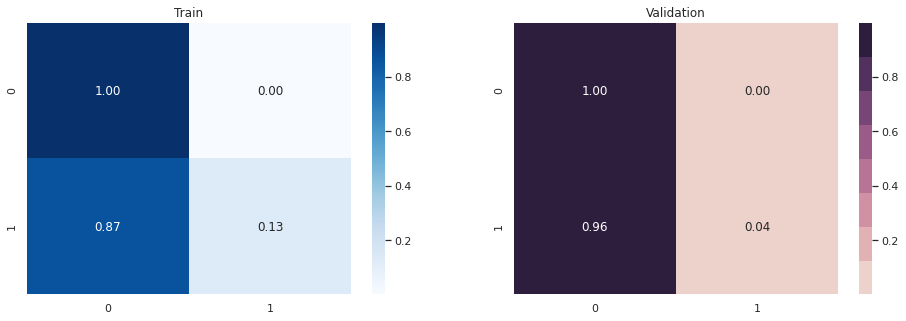

Fold: 2


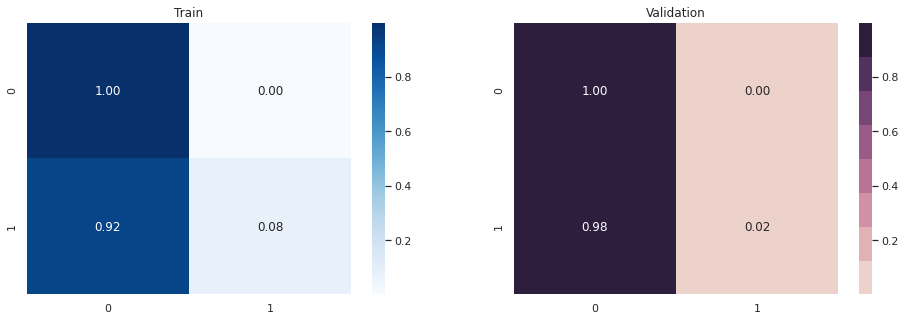

Fold: 3


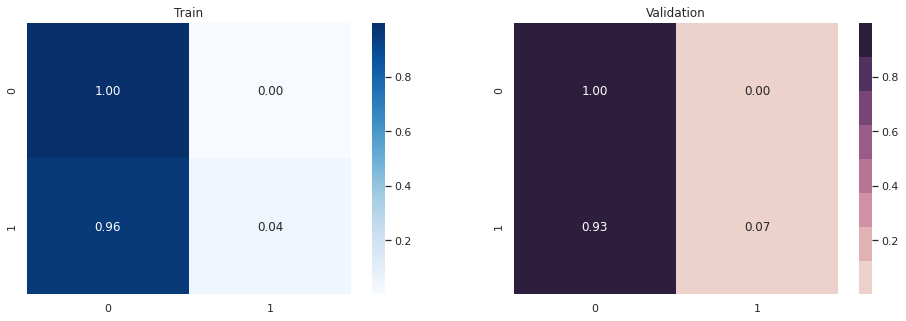

Fold: 4


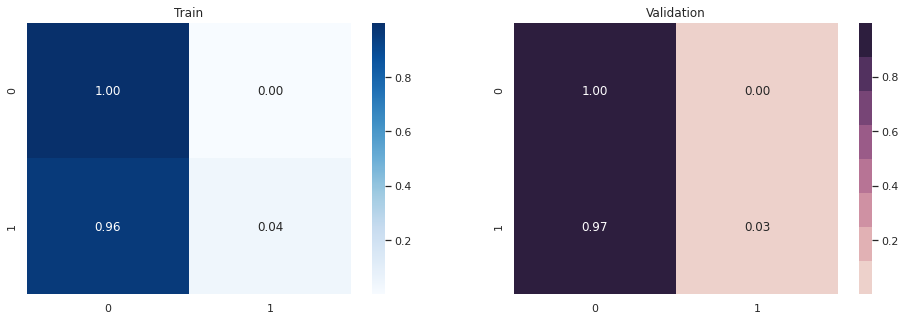

Fold: 5


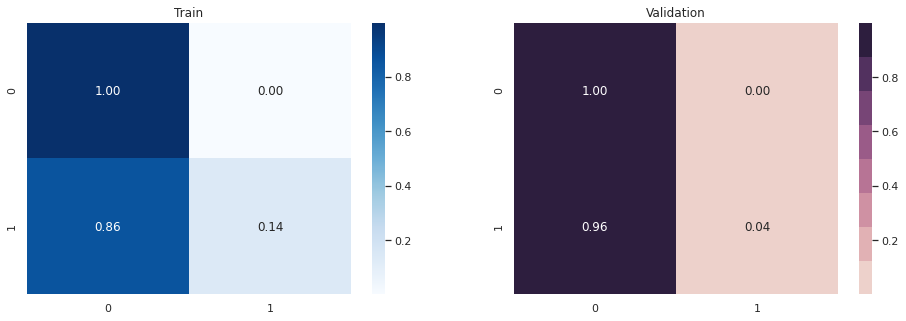

In [27]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 34
Train positive correct predictions: 31
Top 5 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.031244,0.033059,0.030692,0.036319,0.031009,0.030134,0.028067
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.024019,0.025679,0.024744,0.029246,0.018689,0.019894,0.027520
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.022848,0.024906,0.022268,0.026085,0.020058,0.019530,0.026299
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.027947,0.029910,0.029502,0.027842,0.026633,0.021203,0.034552
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.023929,0.026162,0.024922,0.027430,0.018523,0.020404,0.028369


Top 5 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.025716,0.029729,0.025898,0.031017,0.020556,0.020769,0.030341
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.377058,0.416280,0.514712,0.249341,0.260268,0.147236,0.713735
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.100641,0.097109,0.159327,0.181103,0.096761,0.039498,0.026515
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.062612,0.061391,0.105272,0.060895,0.041101,0.044071,0.061719
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.083600,0.099018,0.150196,0.049191,0.068045,0.063172,0.087396


Top 5 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.525239,0.460516,0.750185,0.724373,0.553333,0.117829,0.480472
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.599951,0.581220,0.741714,0.461147,0.795816,0.197810,0.803269
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.521060,0.591954,0.674372,0.579166,0.607501,0.407646,0.336616
5361,ISIC_1698942,male,75.0,torso,melanoma,1,0.511410,0.493137,0.434466,0.591375,0.768209,0.174419,0.588580
5440,ISIC_1728564,male,60.0,lower extremity,melanoma,1,0.519871,0.438382,0.502876,0.713324,0.749511,0.208752,0.424891


,age_approx,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5,pred,pred_best
count,32648.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000
mean,48.812485,0.017772,0.041689,0.036828,0.033095,0.029715,0.041138,0.036493,0.040681
std,14.393434,0.132124,0.056807,0.041683,0.046984,0.022257,0.054248,0.038965,0.041359
min,0.000000,0.000000,0.013681,0.000743,0.015342,0.016057,0.018890,0.016536,0.019099
25%,40.000000,0.000000,0.023941,0.026380,0.019324,0.021035,0.026801,0.023978,0.026703
50%,50.000000,0.000000,0.025899,0.028470,0.021574,0.023588,0.028161,0.025578,0.028755
75%,60.000000,0.000000,0.032175,0.032774,0.028365,0.029222,0.032926,0.031619,0.035354
max,90.000000,1.000000,0.961485,0.935683,0.887963,0.802175,0.973030,0.856075,0.826080


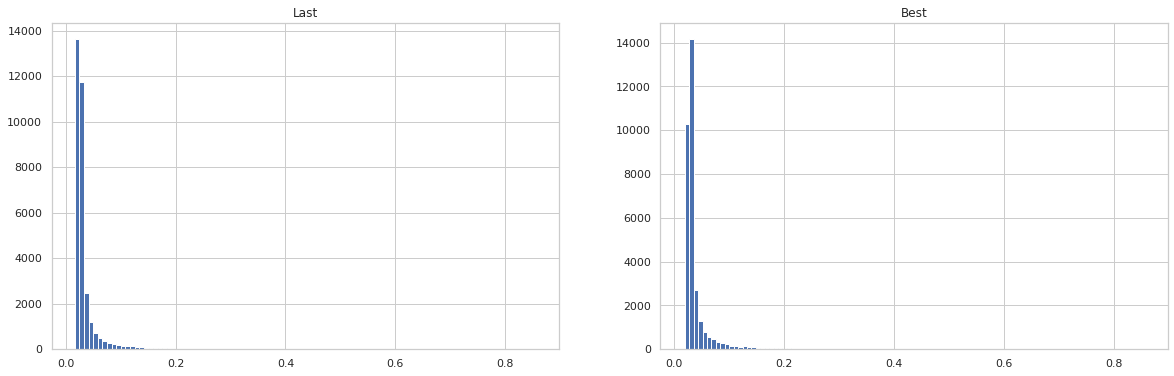

In [28]:
#@title
k_fold['pred'] = 0
k_fold_best['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_USED_FOLDS']
    k_fold_best['pred'] += k_fold_best[f'pred_fold_{n_fold+1}'] / config['N_USED_FOLDS']

k_fold['pred_best'] = k_fold_best['pred']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 5 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(5))

print('Top 5 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(5))

print('Top 5 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(5))

display(k_fold.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 6))
ax1.hist(k_fold['pred'], bins=100)
ax2.hist(k_fold['pred_best'], bins=100)
ax1.set_title('Last')
ax2.set_title('Best')
plt.show()

# Visualize test predictions

Test predictions 7|10975
Test predictions (last) 6|10976
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.030321,0.027712
1,ISIC_0052349,male,40.0,lower extremity,0.025299,0.023237
2,ISIC_0058510,female,55.0,torso,0.026647,0.024387
3,ISIC_0073313,female,50.0,torso,0.027205,0.023584
4,ISIC_0073502,female,45.0,lower extremity,0.030694,0.029264
5,ISIC_0074618,male,50.0,lower extremity,0.034280,0.028205
6,ISIC_0076801,male,45.0,upper extremity,0.027400,0.024961
7,ISIC_0077586,male,50.0,lower extremity,0.040858,0.038307
8,ISIC_0082004,female,45.0,torso,0.035210,0.033232
9,ISIC_0082785,male,65.0,lower extremity,0.037435,0.034360


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
2293,ISIC_2170268,female,80.0,upper extremity,0.518292,0.542571
2750,ISIC_2568903,male,85.0,upper extremity,0.649226,0.593574
3045,ISIC_2839742,male,70.0,upper extremity,0.535293,0.542536
4332,ISIC_4000026,male,90.0,torso,0.509222,0.570693
5424,ISIC_4975524,male,75.0,torso,0.601198,0.539286
6058,ISIC_5541445,male,85.0,upper extremity,0.582646,0.549713
8863,ISIC_8059373,male,55.0,torso,0.546571,0.451152


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
2293,ISIC_2170268,female,80.0,upper extremity,0.518292,0.542571
2750,ISIC_2568903,male,85.0,upper extremity,0.649226,0.593574
3045,ISIC_2839742,male,70.0,upper extremity,0.535293,0.542536
4332,ISIC_4000026,male,90.0,torso,0.509222,0.570693
5424,ISIC_4975524,male,75.0,torso,0.601198,0.539286
6058,ISIC_5541445,male,85.0,upper extremity,0.582646,0.549713


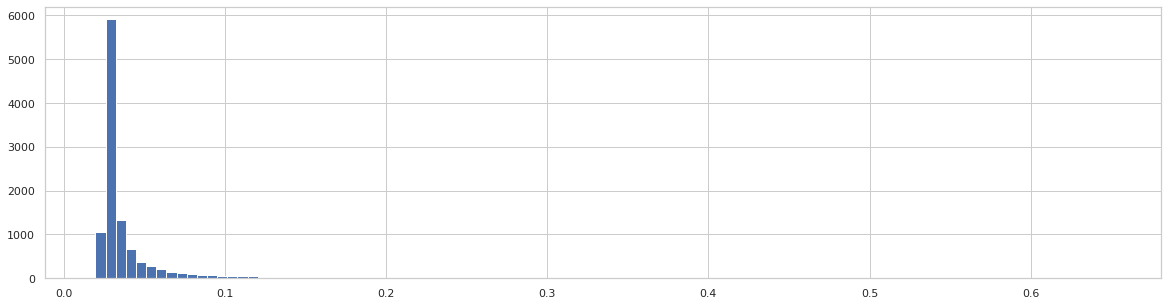

In [29]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(test['target'], bins=100)
plt.show()

# Test set predictions

In [30]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.030321,0.027712,0.029016
1,ISIC_0052349,0.025299,0.023237,0.024268
2,ISIC_0058510,0.026647,0.024387,0.025517
3,ISIC_0073313,0.027205,0.023584,0.025394
4,ISIC_0073502,0.030694,0.029264,0.029979
5,ISIC_0074618,0.034280,0.028205,0.031243
6,ISIC_0076801,0.027400,0.024961,0.026181
7,ISIC_0077586,0.040858,0.038307,0.039582
8,ISIC_0082004,0.035210,0.033232,0.034221
9,ISIC_0082785,0.037435,0.034360,0.035897


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.042983,0.039019,0.041001
std,0.043515,0.041181,0.042157
min,0.019629,0.017211,0.018420
25%,0.027157,0.024364,0.025809
50%,0.029467,0.026542,0.027932
75%,0.038206,0.034295,0.036427
max,0.649226,0.593574,0.621400
